In [4]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=e71fbe8f7b1d34ef0189f3063f67f54c1e6458a6235c0fde0fd967d258a8a8d9
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [5]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import time
from skimage.metrics import structural_similarity as ssim
from pyswarm import pso

# Function to load and preprocess images
def load_images(directory, img_size):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)

    return np.array(images)

# Set image directory, size, and number of classes
image_dir = '/content/drive/MyDrive/BRATS20/Preprocess_BraTS20_flair/Tumor'
img_size = (128, 128)

# Load and preprocess images
x_train = load_images(image_dir, img_size)

# Function to define the generator model
def build_generator(latent_dim, img_size):
    generator_input = Input(shape=(latent_dim,))
    x = Dense(256 * 32 * 32, activation='relu')(generator_input)
    x = Reshape((32, 32, 256))(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    generator_output = x

    generator_model = Model(generator_input, generator_output)
    return generator_model

# Function to define the discriminator model
def build_discriminator(img_size):
    discriminator_input = Input(shape=(img_size[0], img_size[1], 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(discriminator_input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    discriminator_output = Dense(1, activation='sigmoid')(x)

    discriminator_model = Model(discriminator_input, discriminator_output)
    discriminator_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator_model

# Function to define and compile the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan_model = Model(gan_input, gan_output)
    gan_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return gan_model

# Function to train the GAN and calculate SSIM
def train_gan(generator, discriminator, gan, x_train, latent_dim, epochs, batch_size):
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        labels_real = np.ones((batch_size, 1))

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_images = generator.predict(noise)
        labels_fake = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, labels_real)
        d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator (discriminator weights are frozen)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, labels_gan)
        print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
        print(f"Iteration {current_iteration}")
        # Calculate SSIM between real and generated images
        if epoch % 100 == 0:
            ssim_values = []
            for i in range(16):
                real_img = real_images[i] * 255.0
                real_img = real_img.astype(np.uint8)
                generated_img = generated_images[i] * 255.0
                generated_img = generated_img.astype(np.uint8)
                ssim_val = ssim(real_img, generated_img, multichannel=True)
                ssim_values.append(ssim_val)

            average_ssim = np.mean(ssim_values)
            print(f"Average SSIM: {average_ssim},Latent dim: {latent_dim}")

            # Save generated images
            elapsed_time = time.time() - start_time
            print(f"Time: {elapsed_time:.2f} seconds")
            generated_images = generator.predict(np.random.normal(0, 1, (16, latent_dim)))
            generated_images = generated_images * 255.0
            generated_images = generated_images.astype(np.uint8)
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i])
                plt.axis('off')
            plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
            plt.close()

    # Close the training loop by printing the total time
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return average_ssim  # Return the average SSIM value

# Train GAN
epochs = 1000
batch_size = 64

current_iteration =1

def round_to_nearest(value, step):
    return int(np.round(value / step) * step)

# Fitness function for PSO
def fitness_function(latent_dim_values):
    global latent_dim, current_iteration
    latent_dim = int(round_to_nearest(latent_dim_values[0], 50))  # Round to the nearest multiple of 50

    generator = build_generator(latent_dim, img_size)
    discriminator = build_discriminator(img_size)
    gan = build_gan(generator, discriminator)


    avg_ssim = train_gan(generator, discriminator, gan, x_train, latent_dim, epochs, batch_size)
    current_iteration = current_iteration +1
    return -avg_ssim  # Negative SSIM since PSO minimizes the objective function

# Set the lower and upper bounds of the latent_dim
lb = [100]
ub = [500]

# Optimize the latent_dim using PSO
best_latent_dim, best_fitness = pso(fitness_function, lb, ub, swarmsize=2, maxiter=4)

# Print the results int(round_to_nearest(latent_dim_values[0], 50))
print('Best latent dimension:', int(best_latent_dim))
print('Best latent dimension:', int(round_to_nearest(best_latent_dim, 50)))
print('Best fitness (negative SSIM):', best_fitness)

2/2 [==============================] - 3s 5ms/step
Epoch 1/1000 [D loss: 10.593799114227295 | D accuracy: 31.25] [G loss: 1.446599006652832]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 [D loss: 0.29334940016269684 | D accuracy: 100.0] [G loss: 1.6395645141601562]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 [D loss: 0.9930508732795715 | D accuracy: 50.0] [G loss: 2.202167272567749]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 [D loss: 0.2872679680585861 | D accuracy: 96.875] [G loss: 2.1406970024108887]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 [D loss: 0.8521003621863201 | D accuracy: 77.34375] [G loss: 1.4038975238800049]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.9387693405151367 | D accuracy: 53.125] [G loss: 0.9640878438949585]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 7/1000 [D loss: 

<ipython-input-5-53011f8c43eb>:105: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(real_img, generated_img, multichannel=True)


2/2 [==============================] - 0s 5ms/step
Epoch 101/1000 [D loss: 0.3249308541417122 | D accuracy: 90.625] [G loss: 4.078441143035889]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 102/1000 [D loss: 0.3346211463212967 | D accuracy: 87.5] [G loss: 4.046455383300781]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 103/1000 [D loss: 0.35731153190135956 | D accuracy: 86.71875] [G loss: 5.560250282287598]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 104/1000 [D loss: 0.3243877589702606 | D accuracy: 89.0625] [G loss: 3.9711551666259766]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 105/1000 [D loss: 0.2967132031917572 | D accuracy: 90.625] [G loss: 4.488922119140625]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 106/1000 [D loss: 0.2813468277454376 | D accuracy: 90.625] [G loss: 3.880986213684082]
Iteration 1
2/2 [==============================] - 0s 5ms/step
Epoch 107/

Total training time: 208.30 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 11.876559734344482 | D accuracy: 0.0] [G loss: 1.285010814666748]
Iteration 2
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 [D loss: 0.2744337171316147 | D accuracy: 100.0] [G loss: 1.425782561302185]
Iteration 2
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 0.9835849180817604 | D accuracy: 50.0] [G loss: 2.3367443084716797]
Iteration 2
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 [D loss: 0.34359991550445557 | D accuracy: 85.9375] [G loss: 2.493591070175171]
Iteration 2
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 [D loss: 0.07543868366337847 | D accuracy: 100.0] [G loss: 2.490811586380005]
Iteration 2
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 [D loss: 0.2153077748916985 | D accuracy: 95.3125] [G loss: 1.9738085269927979]
Iteration 2
2/2 [==============================] - 0s

Total training time: 199.78 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 10.635433465242386 | D accuracy: 46.875] [G loss: 1.0305120944976807]
Iteration 3
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.31500471010804176 | D accuracy: 100.0] [G loss: 1.1025573015213013]
Iteration 3
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 1.2431625723838806 | D accuracy: 50.0] [G loss: 1.6349900960922241]
Iteration 3
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.41997066140174866 | D accuracy: 89.84375] [G loss: 1.6747901439666748]
Iteration 3
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.1839014166034758 | D accuracy: 100.0] [G loss: 1.376262903213501]
Iteration 3
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 [D loss: 0.965501507591398 | D accuracy: 71.09375] [G loss: 1.0210920572280884]
Iteration 3
2/2 [=============================

Total training time: 199.36 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 15.849423348903656 | D accuracy: 26.5625] [G loss: 1.1160396337509155]
Iteration 4
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 [D loss: 0.37191295623779297 | D accuracy: 100.0] [G loss: 1.1707327365875244]
Iteration 4
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 [D loss: 0.5655815899372101 | D accuracy: 95.3125] [G loss: 0.07812722027301788]
Iteration 4
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 [D loss: 3.784008186790743 | D accuracy: 50.0] [G loss: 1.8786919116973877]
Iteration 4
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 [D loss: 0.2974198907613754 | D accuracy: 96.09375] [G loss: 2.011282205581665]
Iteration 4
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.17076601792359725 | D accuracy: 100.0] [G loss: 1.6580419540405273]
Iteration 4
2/2 [============================

Total training time: 195.77 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 13.373143941164017 | D accuracy: 38.28125] [G loss: 1.2683751583099365]
Iteration 5
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.30700650811195374 | D accuracy: 100.0] [G loss: 1.3087372779846191]
Iteration 5
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 1.6721756309270859 | D accuracy: 50.0] [G loss: 2.2313201427459717]
Iteration 5
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.2541124001145363 | D accuracy: 96.09375] [G loss: 3.062378168106079]
Iteration 5
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.04909996788273929 | D accuracy: 100.0] [G loss: 3.6430134773254395]
Iteration 5
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 [D loss: 0.13495526127047697 | D accuracy: 96.875] [G loss: 2.531642198562622]
Iteration 5
2/2 [============================

Total training time: 198.71 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 17.105594873428345 | D accuracy: 50.0] [G loss: 1.233745813369751]
Iteration 6
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.32770654559135437 | D accuracy: 100.0] [G loss: 1.5491732358932495]
Iteration 6
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 0.5272007286548615 | D accuracy: 98.4375] [G loss: 1.8432061672210693]
Iteration 6
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.10790765914134681 | D accuracy: 100.0] [G loss: 2.026638984680176]
Iteration 6
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.33382794447243214 | D accuracy: 86.71875] [G loss: 2.213501453399658]
Iteration 6
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.15197424590587616 | D accuracy: 100.0] [G loss: 1.7835969924926758]
Iteration 6
2/2 [==============================

Total training time: 196.60 seconds
2/2 [==============================] - 0s 6ms/step
Epoch 1/1000 [D loss: 13.386798083782196 | D accuracy: 39.84375] [G loss: 1.123786449432373]
Iteration 7
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.31297875195741653 | D accuracy: 100.0] [G loss: 1.2203540802001953]
Iteration 7
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 1.7642332017421722 | D accuracy: 50.0] [G loss: 1.6256358623504639]
Iteration 7
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.24326692521572113 | D accuracy: 100.0] [G loss: 1.6536716222763062]
Iteration 7
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.30132757985302305 | D accuracy: 88.28125] [G loss: 1.5850796699523926]
Iteration 7
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 [D loss: 0.772733080200851 | D accuracy: 75.78125] [G loss: 1.0137091875076294]
Iteration 7
2/2 [==========================

Total training time: 197.11 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 12.549016773700714 | D accuracy: 28.125] [G loss: 1.1160130500793457]
Iteration 8
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 [D loss: 0.3249272406101227 | D accuracy: 100.0] [G loss: 1.345772624015808]
Iteration 8
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 1.138667605817318 | D accuracy: 50.0] [G loss: 2.444685935974121]
Iteration 8
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 [D loss: 0.2632387652993202 | D accuracy: 94.53125] [G loss: 2.4432930946350098]
Iteration 8
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.21341279029456928 | D accuracy: 93.75] [G loss: 2.227691173553467]
Iteration 8
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.2535655563697219 | D accuracy: 93.75] [G loss: 1.2530406713485718]
Iteration 8
2/2 [==============================] - 0

Total training time: 191.72 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 13.763722658157349 | D accuracy: 47.65625] [G loss: 1.483924388885498]
Iteration 9
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.30326877534389496 | D accuracy: 100.0] [G loss: 1.539579153060913]
Iteration 9
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 2.0557174682617188 | D accuracy: 50.0] [G loss: 2.5601119995117188]
Iteration 9
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.2969045788049698 | D accuracy: 92.96875] [G loss: 2.359027147293091]
Iteration 9
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 [D loss: 1.464568049371337 | D accuracy: 63.28125] [G loss: 2.7623989582061768]
Iteration 9
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 [D loss: 0.5959936380386353 | D accuracy: 77.34375] [G loss: 1.4082392454147339]
Iteration 9
2/2 [===========================

Total training time: 199.90 seconds
2/2 [==============================] - 0s 5ms/step
Epoch 1/1000 [D loss: 15.09662276506424 | D accuracy: 50.0] [G loss: 0.9828318357467651]
Iteration 10
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 [D loss: 0.2773457504808903 | D accuracy: 100.0] [G loss: 1.0769000053405762]
Iteration 10
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 [D loss: 0.4127441346645355 | D accuracy: 100.0] [G loss: 1.216601014137268]
Iteration 10
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.18650111730676144 | D accuracy: 100.0] [G loss: 1.2840616703033447]
Iteration 10
2/2 [==============================] - 0s 6ms/step
Epoch 5/1000 [D loss: 0.21985348570160568 | D accuracy: 100.0] [G loss: 1.3880321979522705]
Iteration 10
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.33679106875206344 | D accuracy: 89.0625] [G loss: 1.2495992183685303]
Iteration 10
2/2 [===========================

In [6]:
latent_dim = int(round_to_nearest(best_latent_dim, 50))
print(latent_dim)
generator = build_generator(latent_dim, img_size)
discriminator = build_discriminator(img_size)
gan = build_gan(generator, discriminator)
avg_ssim = train_gan(generator, discriminator, gan, x_train, latent_dim, epochs, batch_size)

100
2/2 [==============================] - 0s 4ms/step
Epoch 1/1000 [D loss: 13.068538784980774 | D accuracy: 32.03125] [G loss: 2.177788734436035]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 [D loss: 0.15652121603488922 | D accuracy: 100.0] [G loss: 2.772522449493408]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 [D loss: 1.2153639271855354 | D accuracy: 50.0] [G loss: 5.203882217407227]
Iteration 11
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 [D loss: 0.4942510388791561 | D accuracy: 67.1875] [G loss: 4.1205668449401855]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 [D loss: 0.08004700343008153 | D accuracy: 100.0] [G loss: 2.9015371799468994]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 [D loss: 0.33793285632054904 | D accuracy: 85.15625] [G loss: 1.7991681098937988]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 7/

<ipython-input-5-53011f8c43eb>:105: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(real_img, generated_img, multichannel=True)


2/2 [==============================] - 0s 5ms/step
Epoch 101/1000 [D loss: 0.5083210915327072 | D accuracy: 73.4375] [G loss: 2.5707995891571045]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 102/1000 [D loss: 0.4938279390335083 | D accuracy: 77.34375] [G loss: 2.1392455101013184]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 103/1000 [D loss: 0.5751260668039322 | D accuracy: 64.84375] [G loss: 1.801673173904419]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 104/1000 [D loss: 0.625477060675621 | D accuracy: 60.9375] [G loss: 1.4288058280944824]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 105/1000 [D loss: 0.7647945284843445 | D accuracy: 48.4375] [G loss: 1.0827871561050415]
Iteration 11
2/2 [==============================] - 0s 5ms/step
Epoch 106/1000 [D loss: 0.6054372489452362 | D accuracy: 67.96875] [G loss: 1.7411426305770874]
Iteration 11
2/2 [==============================] - 0s 5ms

1/1 [==============================] - 0s 27ms/step


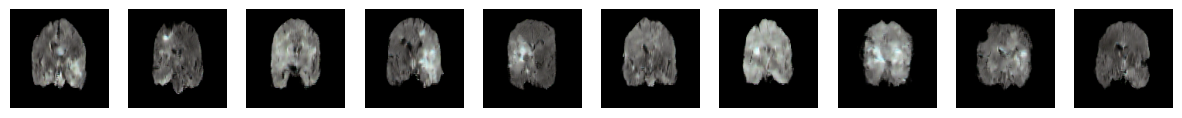

4/4 [==============================] - 0s 55ms/step


In [13]:
# Generate and display 10 samples
num_samples_to_display = 10
generated_images = generator.predict(np.random.normal(0, 1, (num_samples_to_display, latent_dim)))
generated_images = generated_images * 255.0
generated_images = generated_images.astype(np.uint8)

plt.figure(figsize=(15, 3))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()

# Save 500 generated samples
num_samples_to_save = 100
generated_images = generator.predict(np.random.normal(0, 1, (num_samples_to_save, latent_dim)))
generated_images = generated_images * 255.0
generated_images = generated_images.astype(np.uint8)

save_directory = "/content/drive/MyDrive/fakeTflair"
os.makedirs(save_directory, exist_ok=True)

for i in range(num_samples_to_save):
    image = Image.fromarray(generated_images[i])
    image.save(os.path.join(save_directory, f"generated_sample_{i}.png"))


In [15]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import os
from PIL import Image
import tensorflow as tf

def calculate_ssim_psnr(images1, images2):
    ssim_values = []
    psnr_values = []

    for i in range(min(len(images1), len(images2))):  # Use the minimum length to avoid index out of bounds
        img1 = images1[i]
        img2 = images2[i]

        # Ensure both images have the same shape
        if img1.shape != img2.shape:
            img2 = tf.image.resize(img2, size=img1.shape[1:3])

        # Calculate SSIM
        ssim_val = ssim(img1, img2, multichannel=True, channel_axis=-1)  # Use channel_axis instead of multichannel
        ssim_values.append(ssim_val)

        # Calculate PSNR
        psnr_val = psnr(img1, img2)
        psnr_values.append(psnr_val)

    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)

    return avg_ssim, avg_psnr

def calculate_fid(images1, images2):
    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet')
    base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

    # Preprocess and extract features for real images
    real_features = extract_features(images1, base_model)

    # Preprocess and extract features for fake images
    fake_features = extract_features(images2, base_model)

    # Calculate FID
    fid = calculate_frechet_distance(real_features.mean(axis=0), np.cov(real_features, rowvar=False),
                                     fake_features.mean(axis=0), np.cov(fake_features, rowvar=False))

    return fid

def extract_features(images, model):
    features = []

    for img in images:
        # Resize image to the expected input shape of InceptionV3
        img = tf.image.resize(img, size=(299, 299))

        # Make a copy using tf.identity
        img_copy = tf.identity(img)

        # Preprocess image for InceptionV3 model
        img_copy /= 255.0  # Normalize to [0, 1]
        img_copy -= 0.5   # Center around zero
        img_copy *= 2.0   # Scale to [-1, 1]

        img_copy = np.expand_dims(img_copy, axis=0)
        feature = model.predict(img_copy)
        features.append(feature.flatten())

    return np.array(features)

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    eps = 1e-4  # Increased epsilon value for numerical stability

    # Calculate the squared Frobenius norm between the means and covariance matrices
    sum_squared_diff = np.sum((mu1 - mu2)**2)
    trace_sqrt_product = np.trace(sigma1 + sigma2 - 2 * np.sqrt((sigma1 + eps) @ (sigma2 + eps)))

    # Calculate the Frechet distance
    fid = sum_squared_diff + trace_sqrt_product

    # Ensure the FID is non-negative
    fid = np.abs(fid)

    return fid


# Set directories for real and fake images
real_images_directory = '/content/drive/MyDrive/BRATS20/Preprocess_BraTS20_flair/Tumor'
fake_images_directory = '/content/drive/MyDrive/fakeTflair'

# Load real and fake images
real_images = load_images(real_images_directory, img_size)
fake_images = []

for i in range(99):  # Fix the loop indexing
    fake_image_path = os.path.join(fake_images_directory, f"generated_sample_{i+1}.png")  # Adjust index to start from 1
    fake_img = load_img(fake_image_path, target_size=img_size)
    fake_img = img_to_array(fake_img) / 255.0
    fake_images.append(fake_img)

fake_images = np.array(fake_images)

# Calculate SSIM and PSNR
avg_ssim, avg_psnr = calculate_ssim_psnr(real_images, fake_images)
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

# Calculate FID
fid = calculate_fid(real_images, fake_images)
print(f"FID: {fid}")


<ipython-input-15-9a9481797d98>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(img1, img2, multichannel=True, channel_axis=-1)  # Use channel_axis instead of multichannel


Average SSIM: 0.6570581197738647
Average PSNR: 16.005546879377828
1/1 [==============================] - 0s 28ms/step
FID: 21.66309204247707


<ipython-input-15-9a9481797d98>:80: RuntimeWarning: invalid value encountered in sqrt
  trace_sqrt_product = np.trace(sigma1 + sigma2 - 2 * np.sqrt((sigma1 + eps) @ (sigma2 + eps)))
